In [590]:
%matplotlib inline
import importlib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave, imresize
from keras import metrics
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras import backend as K
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array

### Image directories to use for style or base image

In [903]:
donkey = '/Users/dcromp/Documents/projects/deep_learning/pictures/donkey.jpg'
bird = '/Users/dcromp/Documents/projects/deep_learning/pictures/bird.jpg'
kingfisher = '/Users/dcromp/Documents/projects/deep_learning/pictures/kingfisher.jpg'
style = '/Users/dcromp/Documents/projects/deep_learning/pictures/style.jpg'
star_night = '/Users/dcromp/Documents/projects/deep_learning/pictures/star_night.jpg'
dalmo = '/Users/dcromp/Documents/projects/deep_learning/pictures/dalmo.png'
pika = '/Users/dcromp/Documents/projects/deep_learning/pictures/pikachu.jpg'
sea = '/Users/dcromp/Documents/projects/deep_learning/pictures/sea.jpg'
river = '/Users/dcromp/Documents/projects/deep_learning/pictures/river.jpg'
picasso = '/Users/dcromp/Documents/projects/deep_learning/pictures/picasso.jpg'
albert = '/Users/dcromp/Documents/projects/deep_learning/pictures/albert.png'

# Return base image from random pixels

In [592]:
model = VGG19(weights='imagenet', include_top=False) # Model to extract image features
layer = model.get_layer('block5_conv1').output
layer_model = Model(model.input, layer)

In [593]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image


def deprocess_image(x):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((3, 224, 224))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((224, 224, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

x = preprocess_image(kingfisher)

In [594]:
outputs = {l.name: l.output for l in model.layers}
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,5)]

In [595]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(x)]

In [597]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [598]:
def loss_calc(layer, targ):
    return metrics.mse(layer, targ)

In [599]:
loss = sum(loss_calc(l1[0], l2[0]) for l1,l2 in zip(layers, targs))      #metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

In [600]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        
        
        #imsave(f'{path}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

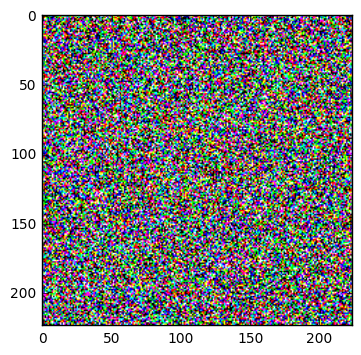

In [601]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [602]:
iterations=10

In [603]:
x = solve_image(evaluator, iterations, x)

Current loss value: 159969.59375
Current loss value: 99570.71875
Current loss value: 77993.7890625
Current loss value: 66387.5859375
Current loss value: 59435.5859375
Current loss value: 54587.96875
Current loss value: 50683.71875
Current loss value: 47598.390625
Current loss value: 44760.671875
Current loss value: 42281.7070312


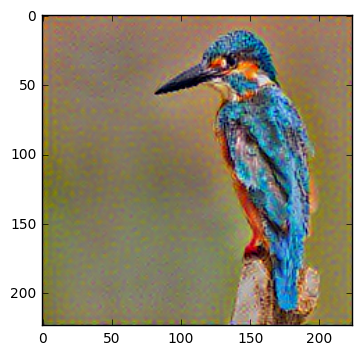

In [604]:
plt.imshow(deprocess_image(x))

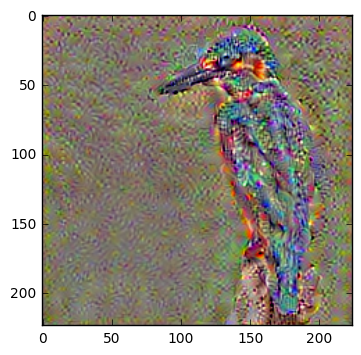

In [580]:
plt.imshow(deprocess_image(x))

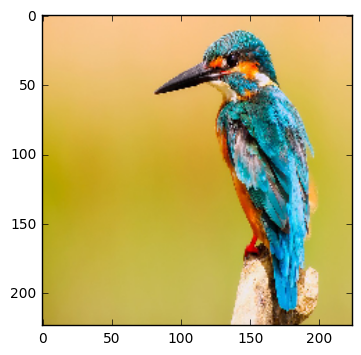

In [247]:
plt.imshow(img)

# Return Style of an Image

In [607]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_dim_ordering() == 'th':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [611]:
model = VGG19(weights='imagenet', include_top=False) 
outputs = {l.name: l.output for l in model.layers}
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [612]:
style_arr = preprocess_image(style)
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [613]:
def style_loss(layer, targ):
    return metrics.mse(gram_matrix(layer), gram_matrix(targ))

In [614]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))      #metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

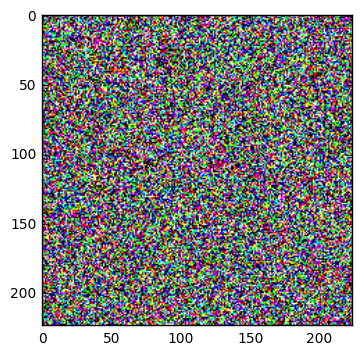

In [620]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [621]:
x = solve_image(evaluator, iterations, x)

Current loss value: 1.16309711535e+16
Current loss value: 2.85628532208e+15
Current loss value: 7.48853586297e+14
Current loss value: 1.17404508094e+14
Current loss value: 4.78303622267e+13
Current loss value: 2.96500991099e+13
Current loss value: 2.23871542231e+13
Current loss value: 1.84554639852e+13
Current loss value: 1.57463588372e+13
Current loss value: 1.37855647089e+13


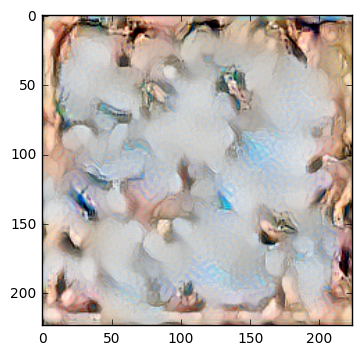

In [622]:
plt.imshow(deprocess_image(x))

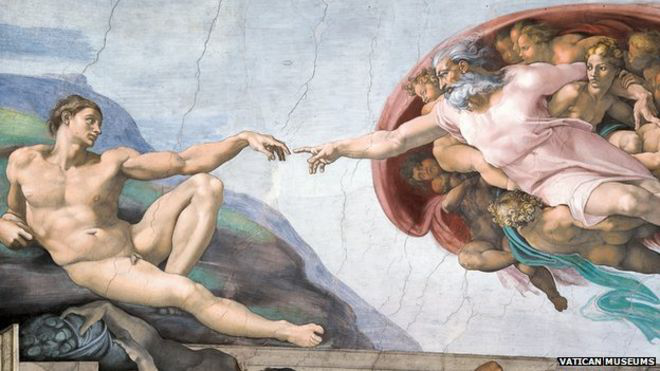

In [18]:
style_img=Image.open(style); style_img

# Content + Style

In [923]:
src = preprocess_image(albert)

In [924]:
model = VGG19(weights='imagenet', include_top=False) 
outputs = {l.name: l.output for l in model.layers}

In [925]:
style_arr = preprocess_image(picasso)

In [926]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_outputs = [outputs['block{}_conv1'.format(o)] for o in range(1,5)]

In [927]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [928]:
content_model = Model(model.input, content_outputs)
content_targs = [K.variable(o) for o in layers_model.predict(src)]

In [929]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [937]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts)) * 0.0000000001
loss += sum(loss_calc(l1[0], l2[0]) for l1,l2 in zip(content_outputs, content_targs))
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(transfer_fn, shp)

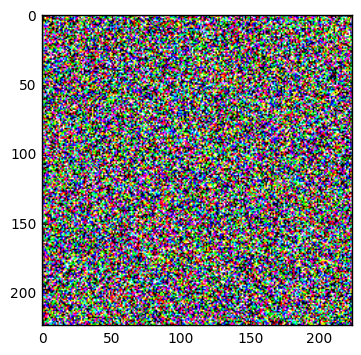

In [931]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [944]:
iterations = 10
x = solve_image(evaluator, iterations, x)

Current loss value: 506713.4375
Current loss value: 269495.625
Current loss value: 195522.390625
Current loss value: 153206.5
Current loss value: 132553.3125
Current loss value: 121847.921875
Current loss value: 112758.882812
Current loss value: 107999.546875
Current loss value: 104829.515625
Current loss value: 103004.53125


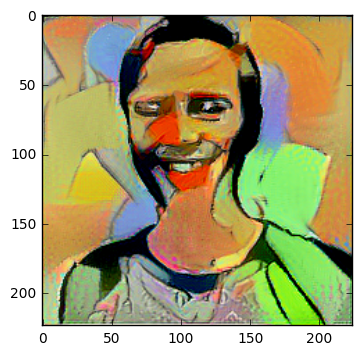

In [945]:
plt.imshow(deprocess_image(x))

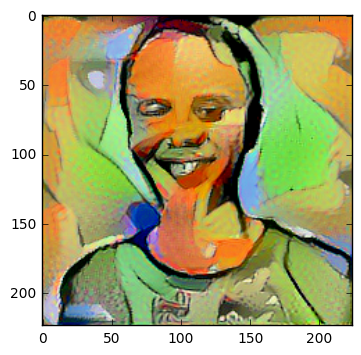

In [914]:
plt.imshow(deprocess_image(x))

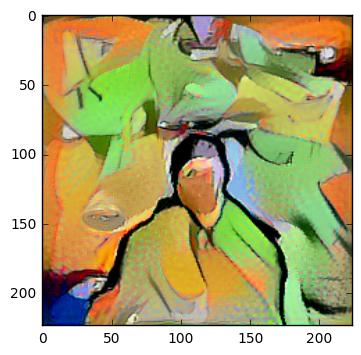

In [902]:
plt.imshow(deprocess_image(x))

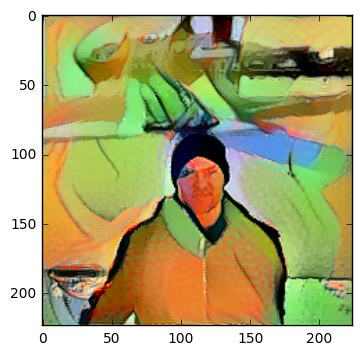

In [898]:
plt.imshow(deprocess_image(x))

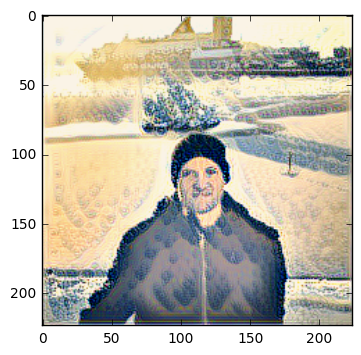

In [874]:
plt.imshow(deprocess_image(x))

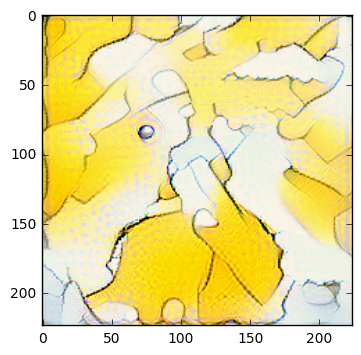

In [832]:
plt.imshow(deprocess_image(x))

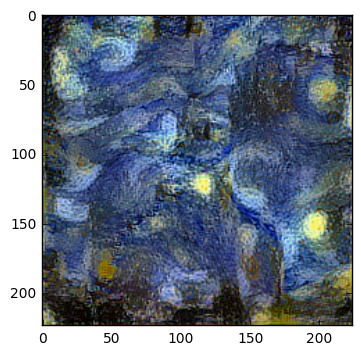

In [792]:
plt.imshow(deprocess_image(x))

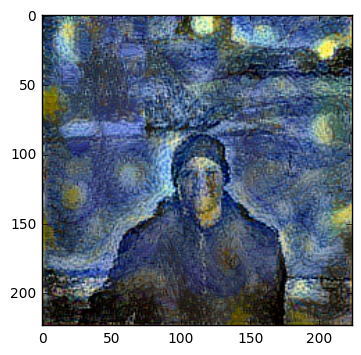

In [781]:
plt.imshow(deprocess_image(x))

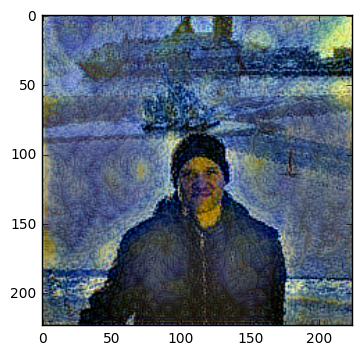

In [777]:
plt.imshow(deprocess_image(x))

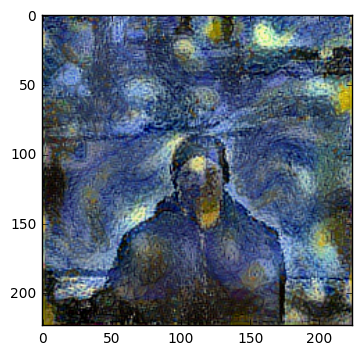

In [766]:
plt.imshow(deprocess_image(x))

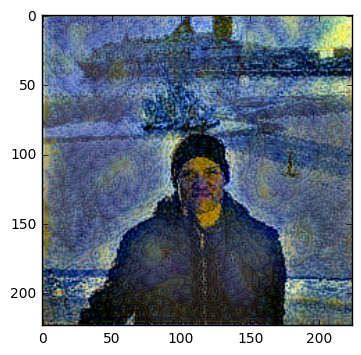

In [755]:
plt.imshow(deprocess_image(x))

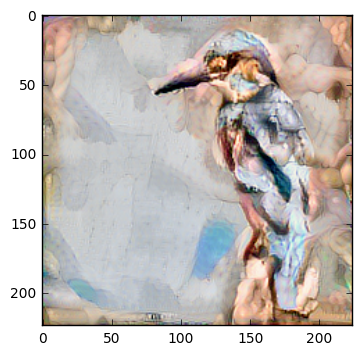

In [723]:
plt.imshow(deprocess_image(x))

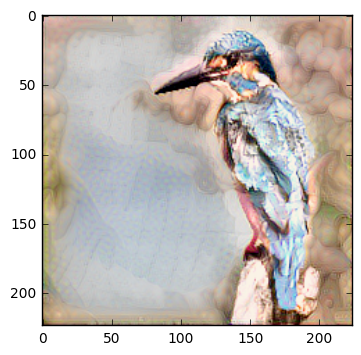

In [713]:
plt.imshow(deprocess_image(x))